## 1. Import Libraries

In [57]:
!pip3 install xgboost

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb # Added import for XGBoost
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## 2. Load Data

In [59]:
# Load the preprocessed data
df = pd.read_csv('../../Data Preprocessing/alonhadat_processed.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (14426, 17)

First few rows:


,address,area,bedrooms,date,floors,price,title,road,ward,district,address_complete,road_cat,ward_cat,district_cat,price_converted,is_price_per_m2,price_per_m2
0,"Đường Nguyễn Văn Cừ, Phường Gia Thụy, Quận Lon...",80,1,Hôm nay,1,"7,5 tỷ","🥇ĐẤT NGUYỄN VĂN CỪ 80M, MT8M, MẢNH ĐẤT RỘNG TH...",Nguyễn Văn Cừ,Gia Thụy,Long Biên,1,564,54,11,7500.00,False,93.75
1,"Đường Ngọc Lâm, Phường Ngọc Lâm, Quận Long Biê...",36,3,Hôm nay,6,"8,65 tỷ","🔥CÒN DUY NHẤT 1 CĂN GIÁ RẺ, NGỌC LÂM 36M, 6T G...",Ngọc Lâm,Ngọc Lâm,Long Biên,1,603,157,11,8650.00,False,240.28
2,"Đường Ngô Gia Tự, Phường Đức Giang, Quận Long ...",56,1,Hôm nay,1,"15,5 tỷ","👉MẶT PHỐ, NGÔ GIA TỰ, 56M, MT4M, VỈA HÈ ĐÁ BÓN...",Ngô Gia Tự,Đức Giang,Long Biên,1,587,390,11,15500.00,False,276.79
3,"Đường Phúc Lợi, Phường Phúc Lợi, Quận Long Biê...",32,3,Hôm nay,5,"5,2 tỷ","🥇CĂN DUY NHẤT, NGÕ THÔNG, Ô TÔ , LÔ GÓC, PHÚC ...",Phúc Lợi,Phúc Lợi,Long Biên,1,667,193,11,5200.00,False,162.50
4,"Phố Lệ Mật, Phường Việt Hưng, Quận Long Biên, ...",58,3,Hôm nay,3,7 tỷ,"🏡VIỆT HƯNG, DIỆN TÍCH RỘNG 58m, 3T, MT5m GIÁ C...",Lệ Mật,Việt Hưng,Long Biên,1,445,313,11,7000.00,False,120.69


In [60]:
# Check data types and missing values
print("\nData types and missing values:")
df.info()

# Display descriptive statistics for numeric columns
print("\nDescriptive statistics:")
df.describe()


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14426 entries, 0 to 14425
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   address           14426 non-null  object 
 1   area              14426 non-null  int64  
 2   bedrooms          14426 non-null  int64  
 3   date              14426 non-null  object 
 4   floors            14426 non-null  int64  
 5   price             14426 non-null  object 
 6   title             14426 non-null  object 
 7   road              14260 non-null  object 
 8   ward              14410 non-null  object 
 9   district          14426 non-null  object 
 10  address_complete  14426 non-null  int64  
 11  road_cat          14426 non-null  int64  
 12  ward_cat          14426 non-null  int64  
 13  district_cat      14426 non-null  int64  
 14  price_converted   14426 non-null  float64
 15  is_price_per_m2   14426 non-null  bool   
 16  price_pe

,area,bedrooms,floors,address_complete,road_cat,ward_cat,district_cat,price_converted,price_per_m2
count,14426.00,14426.00,14426.00,14426.00,14426.00,14426.00,14426.00,14426.00,14426.00
mean,57.46,4.22,4.64,0.99,582.51,193.47,12.61,13134.79,228.73
std,26.51,1.67,1.48,0.11,315.48,110.17,8.56,8247.17,92.59
min,6.00,1.00,1.00,0.00,-1.00,-1.00,1.00,0.00,0.00
25%,40.00,3.00,4.00,1.00,348.00,109.00,6.00,6980.00,167.32
50%,50.00,4.00,5.00,1.00,572.00,177.00,10.00,10500.00,216.01
75%,68.00,5.00,5.00,1.00,848.00,294.50,22.00,17400.00,285.71
max,181.00,10.00,9.00,1.00,1144.00,392.00,28.00,42400.00,483.87


## 3. Setting Price Converted as Target Variable

In this notebook, we'll use `price_converted` (the absolute price) as our target variable instead of `price_per_m2` to test our assumption that predicting the absolute price might yield different insights.

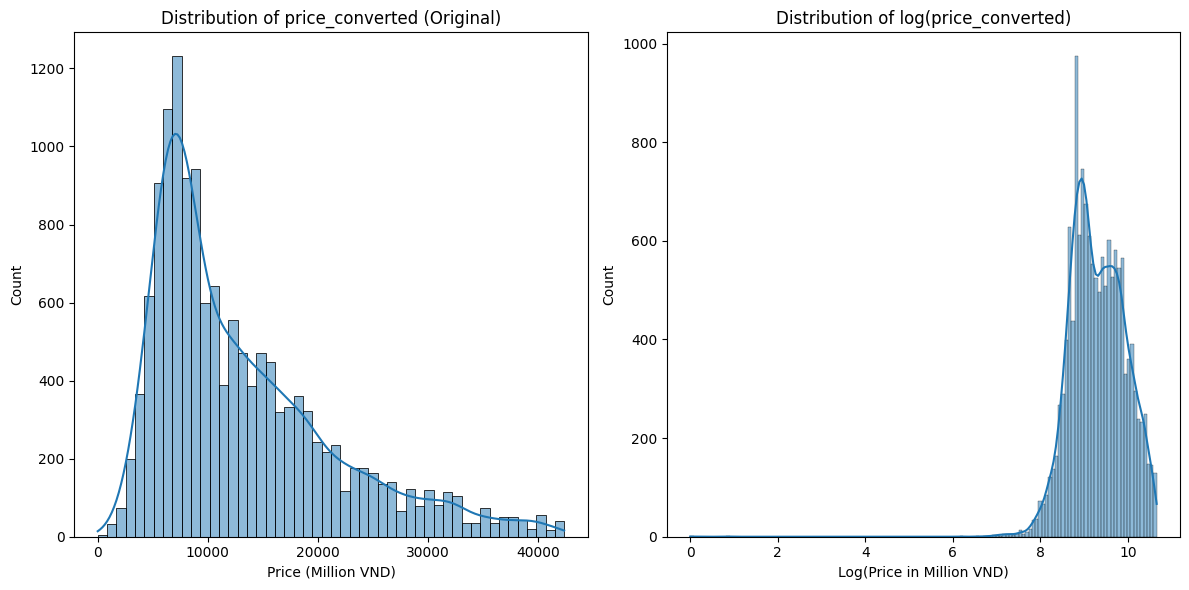

Original price_converted skewness: 1.2241
Log-transformed price_converted skewness: -0.4230


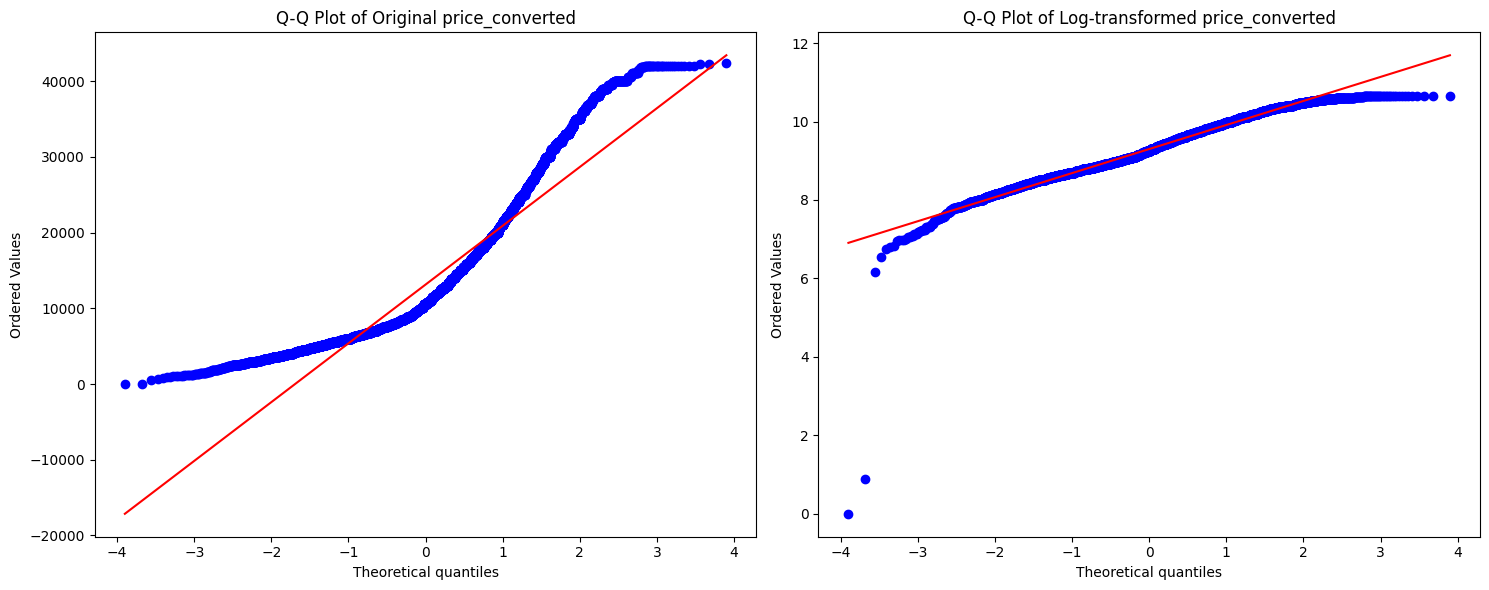

In [61]:
# Analyze the price_converted distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['price_converted'], kde=True)
plt.title('Distribution of price_converted (Original)')
plt.xlabel('Price (Million VND)')

# Create log-transformed version of price_converted for better distribution
df['price_converted_log'] = np.log1p(df['price_converted'])

plt.subplot(1, 2, 2)
sns.histplot(df['price_converted_log'], kde=True)
plt.title('Distribution of log(price_converted)')
plt.xlabel('Log(Price in Million VND)')

plt.tight_layout()
plt.show()

# Calculate skewness to decide if log transformation is helpful
original_skew = stats.skew(df['price_converted'].dropna())
log_skew = stats.skew(df['price_converted_log'].dropna())
print(f"Original price_converted skewness: {original_skew:.4f}")
print(f"Log-transformed price_converted skewness: {log_skew:.4f}")

# Create a QQ plot to check normality of both distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
stats.probplot(df['price_converted'].dropna(), plot=ax1)
ax1.set_title('Q-Q Plot of Original price_converted')

stats.probplot(df['price_converted_log'].dropna(), plot=ax2)
ax2.set_title('Q-Q Plot of Log-transformed price_converted')

plt.tight_layout()
plt.show()

## 4. Feature Selection and Data Preparation

We'll create relevant features for our model predicting the absolute price (`price_converted`).

Feature set shape: (14426, 10)
Target shape: (14426,)

Feature set sample:


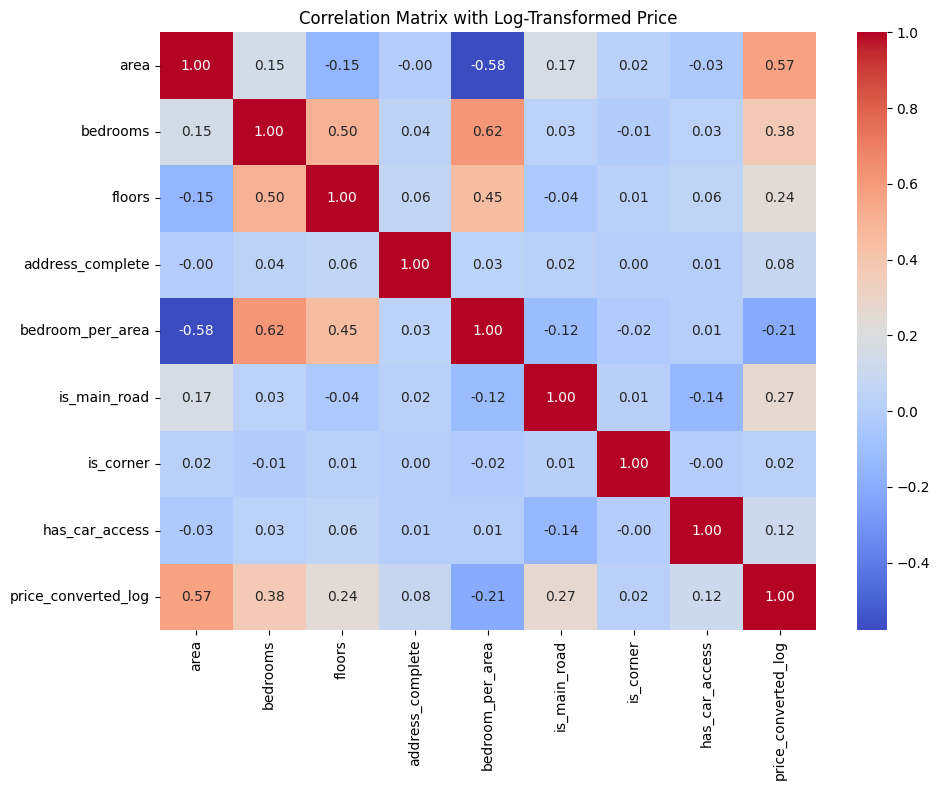


Top correlations with log-transformed price_converted:
price_converted_log    1.00
area                   0.57
bedrooms               0.38
is_main_road           0.27
floors                 0.24
has_car_access         0.12
address_complete       0.08
is_corner              0.02
bedroom_per_area      -0.21
Name: price_converted_log, dtype: float64


In [62]:
# Enhanced feature engineering based on EDA insights
# Create derived features to capture more complex relationships

# Create bedroom density feature
df['bedroom_per_area'] = df['bedrooms'] / df['area']

# Extract property characteristics from title using regex
df['is_corner'] = df['title'].str.contains('GÓC|GÓCH?', case=False, regex=True).astype(int)
df['is_main_road'] = df['title'].str.contains('MẶT PHỐ|MẶT TIỀN|MẶT ĐƯỜNG', case=False, regex=True).astype(int)
df['has_car_access'] = df['title'].str.contains('Ô TÔ|OTO|XE HƠI', case=False, regex=True).astype(int)

# Create district price categories based on median prices
district_price = df.groupby('district')['price_converted'].median().sort_values()
price_percentiles = np.percentile(district_price, [33, 66])
price_labels = ['low_price', 'mid_price', 'high_price']
district_price_category = pd.cut(district_price, 
                                bins=[0] + list(price_percentiles) + [float('inf')], 
                                labels=price_labels)
district_to_price_category = dict(zip(district_price.index, district_price_category))
df['district_price_category'] = df['district'].map(district_to_price_category)

# Select expanded feature set - including area as a key feature for absolute price prediction
numeric_features = ['area', 'bedrooms', 'floors', 'address_complete', 'bedroom_per_area', 
                   'is_main_road', 'is_corner', 'has_car_access']

# Expanded categorical features
categorical_features = ['district', 'district_price_category']

# Define features and target (using price_converted instead of price_per_m2)
X = df[numeric_features + categorical_features].copy()
y = df['price_converted']
y_log = df['price_converted_log']

print("Feature set shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature set sample:")
X.head()

# Visualize correlation with log-transformed target variable
plt.figure(figsize=(10, 8))
# Ensure only numeric columns are used for correlation
numeric_df = X.select_dtypes(include=np.number)
corr_data = pd.concat([numeric_df, y_log], axis=1)
correlation_matrix = corr_data.corr()

# Plot correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Log-Transformed Price')
plt.tight_layout()
plt.show()

# Display top correlations with price_converted_log
price_correlations = correlation_matrix['price_converted_log'].sort_values(ascending=False)
print("\nTop correlations with log-transformed price_converted:")
print(price_correlations)

## 5. Data Preprocessing Pipeline

We'll create a preprocessing pipeline with enhancements for dealing with outliers and skewed data.

In [63]:
# Create preprocessing pipelines with robust transformers for price prediction
numeric_transformer = Pipeline(steps=[
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),  # Better handles skewed features
    ('scaler', RobustScaler())  # Less sensitive to outliers than StandardScaler
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Display the preprocessing pipeline
print("Preprocessing Pipeline:")
print(preprocessor)

Preprocessing Pipeline:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('power',
                                                  PowerTransformer(standardize=False)),
                                                 ('scaler', RobustScaler())]),
                                 ['area', 'bedrooms', 'floors',
                                  'address_complete', 'bedroom_per_area',
                                  'is_main_road', 'is_corner',
                                  'has_car_access']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['district', 'district_price_category'])])


## 6. Outlier Detection and Handling

Let's identify and handle outliers in our key variables, especially in the price_converted target.

Original dataset shape: (14426, 23)
Column: area
Number of outliers: 724 (5.02%)
Outlier thresholds: [-2.00, 110.00]


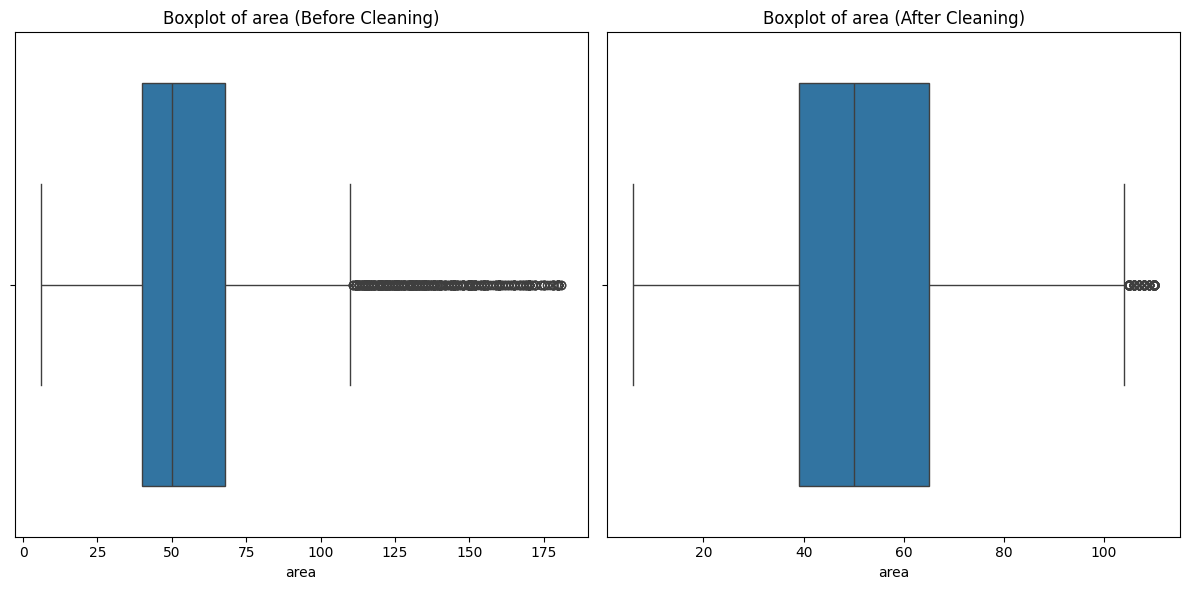

Column: price_converted
Number of outliers: 468 (3.42%)
Outlier thresholds: [-7525.00, 30915.00]


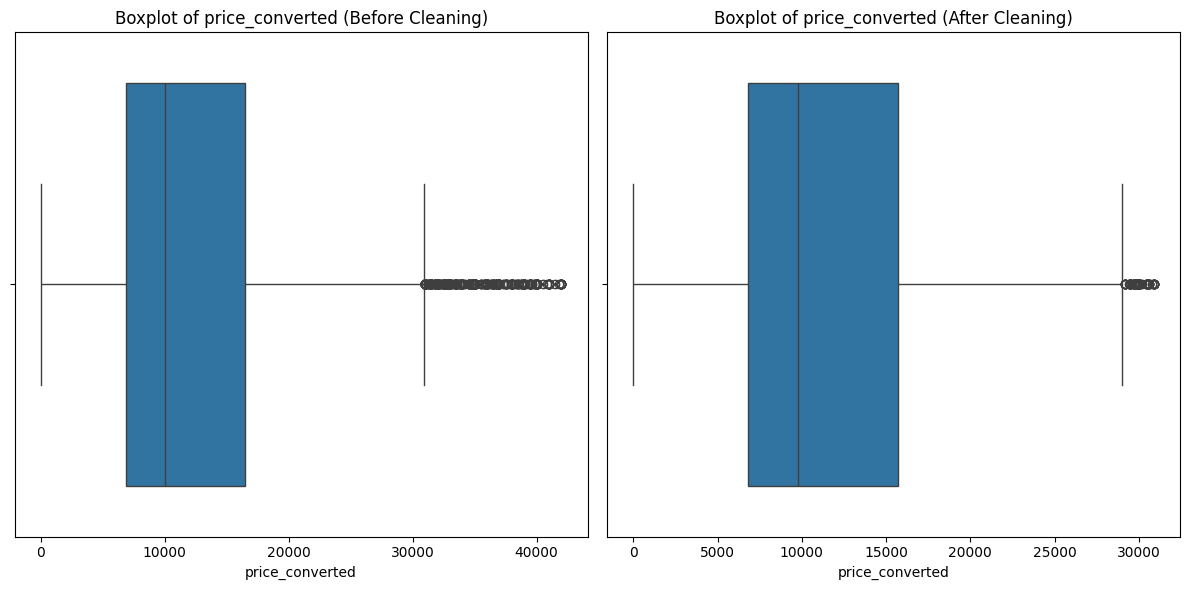

Column: bedrooms
Number of outliers: 378 (2.86%)
Outlier thresholds: [0.00, 8.00]


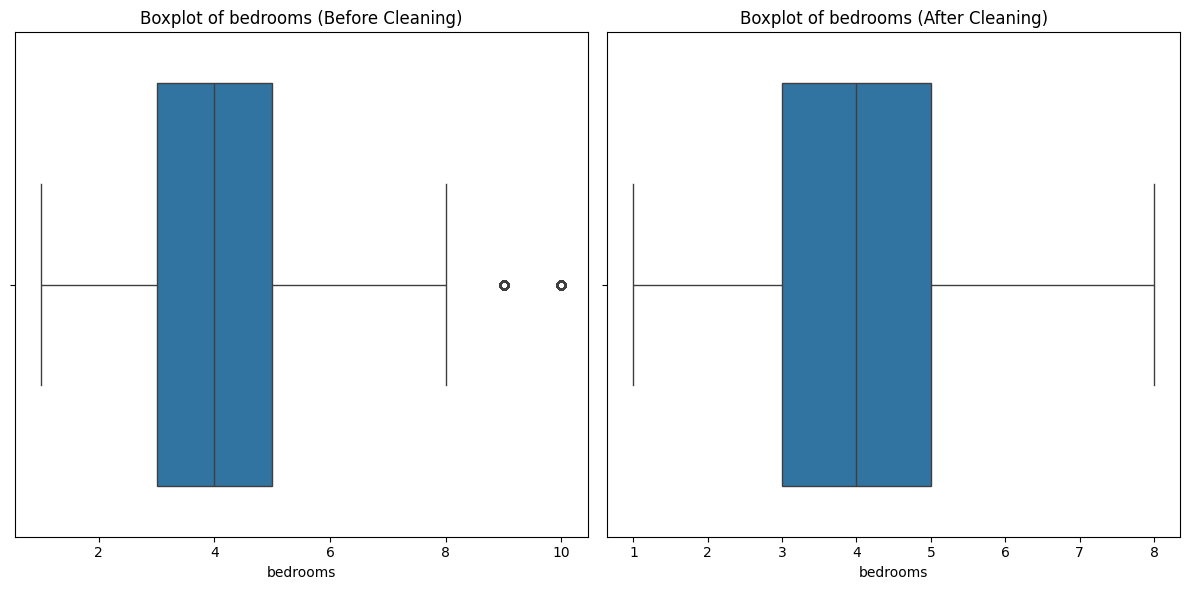

Column: floors
Number of outliers: 1896 (14.75%)
Outlier thresholds: [2.50, 6.50]


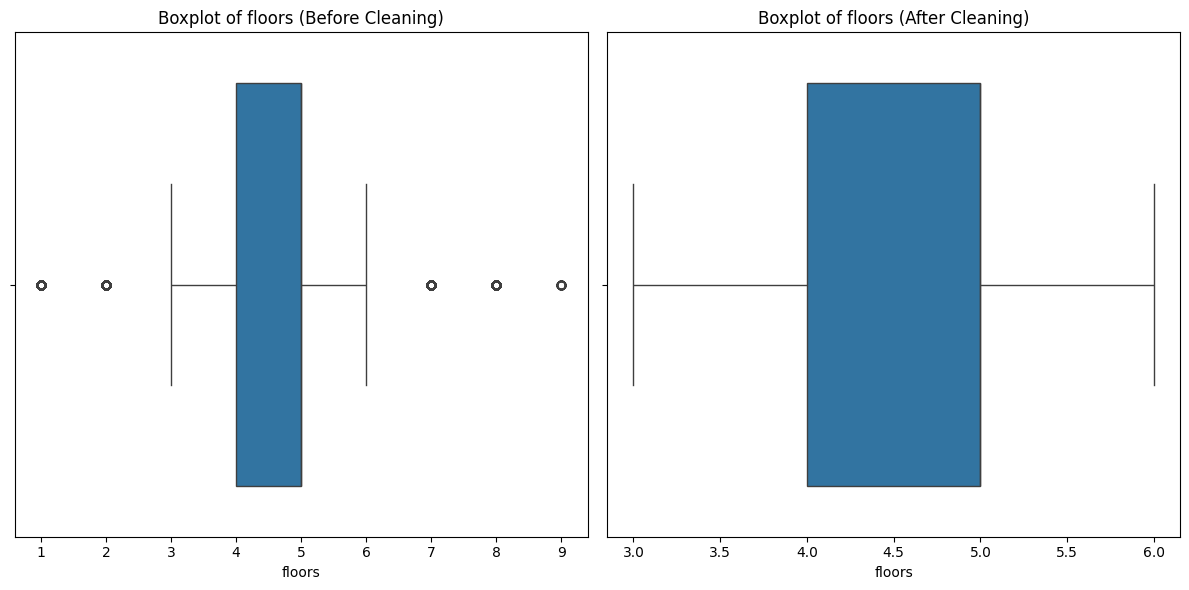


Cleaned dataset shape: (10960, 23)
Removed 3466 records (24.03% of original data)


In [64]:
# Handle outliers using IQR method as identified in the EDA
def detect_and_handle_outliers(df, column, show_plot=True):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    outlier_percentage = len(outliers) / len(df) * 100
    
    print(f"Column: {column}")
    print(f"Number of outliers: {len(outliers)} ({outlier_percentage:.2f}%)")
    print(f"Outlier thresholds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    if show_plot:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.boxplot(x=df[column])
        plt.title(f"Boxplot of {column} (Before Cleaning)")
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=cleaned[column])
        plt.title(f"Boxplot of {column} (After Cleaning)")
        plt.tight_layout()
        plt.show()
    
    return cleaned

# Handle outliers in key numeric columns including price_converted
print("Original dataset shape:", df.shape)

columns_to_clean = ['area', 'price_converted', 'bedrooms', 'floors']
df_clean = df.copy()

for column in columns_to_clean:
    df_clean = detect_and_handle_outliers(df_clean, column)

print("\nCleaned dataset shape:", df_clean.shape)
print(f"Removed {len(df) - len(df_clean)} records ({(len(df) - len(df_clean))/len(df)*100:.2f}% of original data)")

# Update our dataset to use the cleaned version
df = df_clean.copy()

# Update target variables after outlier removal
y = df['price_converted']
df['price_converted_log'] = np.log1p(df['price_converted'])
y_log = df['price_converted_log']

## 7. Split Data

In [65]:
# Split the data into training and testing sets
X = df[numeric_features + categorical_features].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
_, _, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (8768, 10)
Testing set shape: (2192, 10)


## 8. XGBoost Model Training

We'll train our XGBoost model with both original and log-transformed price targets.

In [66]:
# Define XGBoost parameters optimized for price_converted prediction
xgb_params = {
    'n_estimators': 600,
    'max_depth': 6,  # Slightly reduced to prevent overfitting on absolute prices
    'eta': 0.01,
    'gamma': 1,
    'subsample': 1,  # Using subsample to improve generalization
    'colsample_bytree': 0.8,  # Using column sampling for better generalization
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Create two XGBoost models - one for original price and one for log-transformed price
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(**xgb_params))
])

xgb_model_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(**xgb_params))
])

## 9. Model Evaluation

We'll evaluate our models on both original and log-transformed price targets.

In [67]:
# Define our comprehensive evaluation function for price prediction
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(model, X_train, X_test, y_train, y_test, y_train_log=None, y_test_log=None, is_log_model=False):
    # Train the model
    if is_log_model and y_train_log is not None:
        model.fit(X_train, y_train_log)
        y_train_pred_log = model.predict(X_train)
        y_test_pred_log = model.predict(X_test)
        # Transform predictions back to original scale for evaluation
        y_train_pred = np.expm1(y_train_pred_log)
        y_test_pred = np.expm1(y_test_pred_log)
        
        # Evaluate on log scale
        train_r2_log = r2_score(y_train_log, y_train_pred_log)
        test_r2_log = r2_score(y_test_log, y_test_pred_log)
        train_rmse_log = np.sqrt(mean_squared_error(y_train_log, y_train_pred_log))
        test_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_test_pred_log))
    else:
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
    # Calculate metrics on original scale
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    
    # Print results
    print(f"Model: {model.__class__.__name__} {'(Log-transformed target)' if is_log_model else '(Original target)'}")
    if is_log_model:
        print("\nLog-transformed Target Metrics:")
        print(f"Training R² (log scale): {train_r2_log:.4f}")
        print(f"Testing R² (log scale): {test_r2_log:.4f}")
        print(f"Training RMSE (log scale): {train_rmse_log:.4f}")
        print(f"Testing RMSE (log scale): {test_rmse_log:.4f}")
    
    print("\nOriginal Scale Metrics:")
    print(f"Training R² Score: {train_r2:.4f}")
    print(f"Testing R² Score: {test_r2:.4f}")
    print(f"Training RMSE: {train_rmse:.2f} million VND")
    print(f"Testing RMSE: {test_rmse:.2f} million VND")
    print(f"Training MAE: {train_mae:.2f} million VND")
    print(f"Testing MAE: {test_mae:.2f} million VND")
    print(f"Training MAPE: {train_mape:.2f}%")
    print(f"Testing MAPE: {test_mape:.2f}%")
    
    # Return predictions and metrics
    metrics = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_mape': train_mape,
        'test_mape': test_mape
    }
    if is_log_model:
        metrics.update({
            'train_r2_log': train_r2_log,
            'test_r2_log': test_r2_log,
            'train_rmse_log': train_rmse_log,
            'test_rmse_log': test_rmse_log
        })
    
    return y_train_pred, y_test_pred, metrics

# Evaluate models with original and log-transformed targets
print("Evaluating XGBoost with original price_converted target...")
y_train_pred_xgb, y_test_pred_xgb, metrics_xgb = evaluate_model(
    xgb_model, X_train, X_test, y_train, y_test
)

print("\nEvaluating XGBoost with log-transformed price_converted target...")
y_train_pred_xgb_log, y_test_pred_xgb_log, metrics_xgb_log = evaluate_model(
    xgb_model_log, X_train, X_test, y_train, y_test, y_train_log, y_test_log, True
)

# Compare models
print("\nModel Comparison:")
print(f"MAPE (Original): {metrics_xgb['test_mape']:.2f}%")
print(f"MAPE (Log-transformed): {metrics_xgb_log['test_mape']:.2f}%")
print(f"RMSE (Original): {metrics_xgb['test_rmse']:.2f} million VND")
print(f"RMSE (Log-transformed): {metrics_xgb_log['test_rmse']:.2f} million VND")
print(f"R² (Original): {metrics_xgb['test_r2']:.4f}")
print(f"R² (Log-transformed): {metrics_xgb_log['test_r2']:.4f}")

# Identify which model is better based on test MAPE
best_model = "Log-transformed" if metrics_xgb_log['test_mape'] < metrics_xgb['test_mape'] else "Original"
print(f"\nBest model based on test MAPE: {best_model}")

Evaluating XGBoost with original price_converted target...
Model: Pipeline (Original target)

Original Scale Metrics:
Training R² Score: 0.7451
Testing R² Score: 0.6942
Training RMSE: 3093.06 million VND
Testing RMSE: 3488.90 million VND
Training MAE: 2244.31 million VND
Testing MAE: 2549.33 million VND
Training MAPE: 151.49%
Testing MAPE: 24.72%

Evaluating XGBoost with log-transformed price_converted target...
Model: Pipeline (Original target)

Original Scale Metrics:
Training R² Score: 0.7451
Testing R² Score: 0.6942
Training RMSE: 3093.06 million VND
Testing RMSE: 3488.90 million VND
Training MAE: 2244.31 million VND
Testing MAE: 2549.33 million VND
Training MAPE: 151.49%
Testing MAPE: 24.72%

Evaluating XGBoost with log-transformed price_converted target...
Model: Pipeline (Log-transformed target)

Log-transformed Target Metrics:
Training R² (log scale): 0.6904
Testing R² (log scale): 0.6943
Training RMSE (log scale): 0.2966
Testing RMSE (log scale): 0.2945

Original Scale Metrics

## 10. Visualize Results

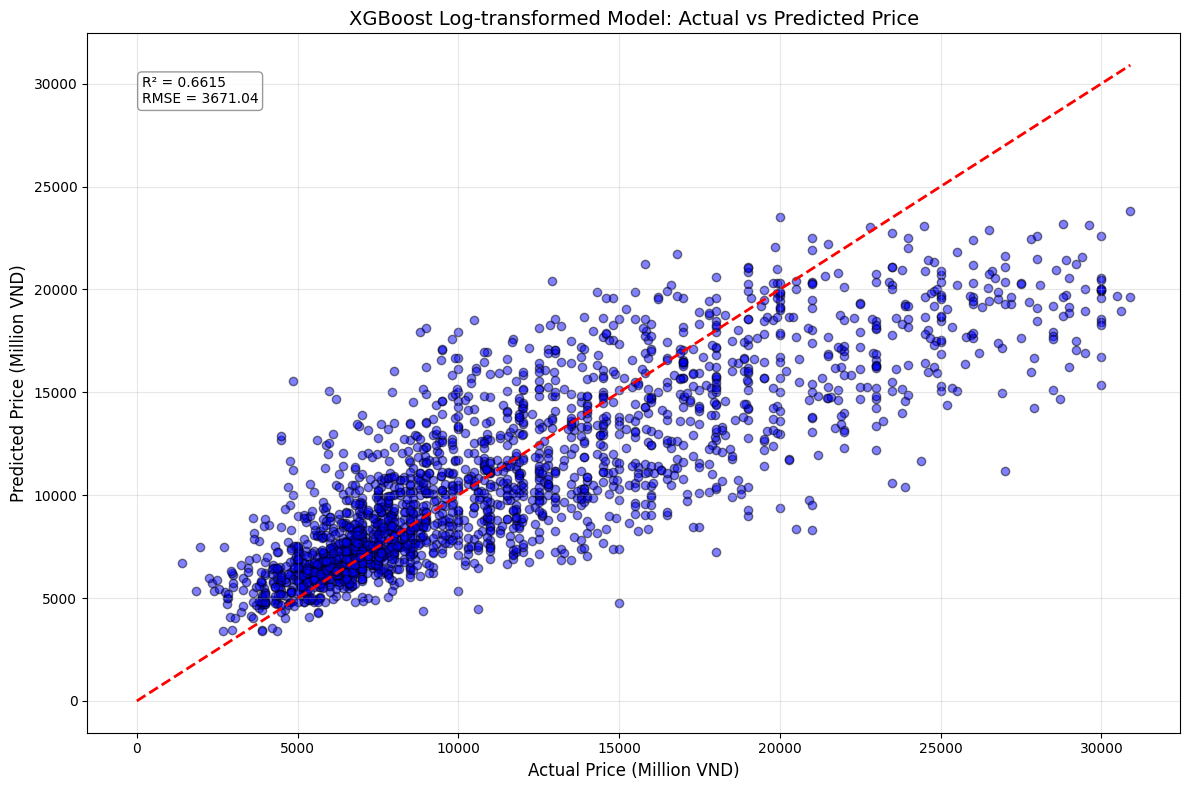

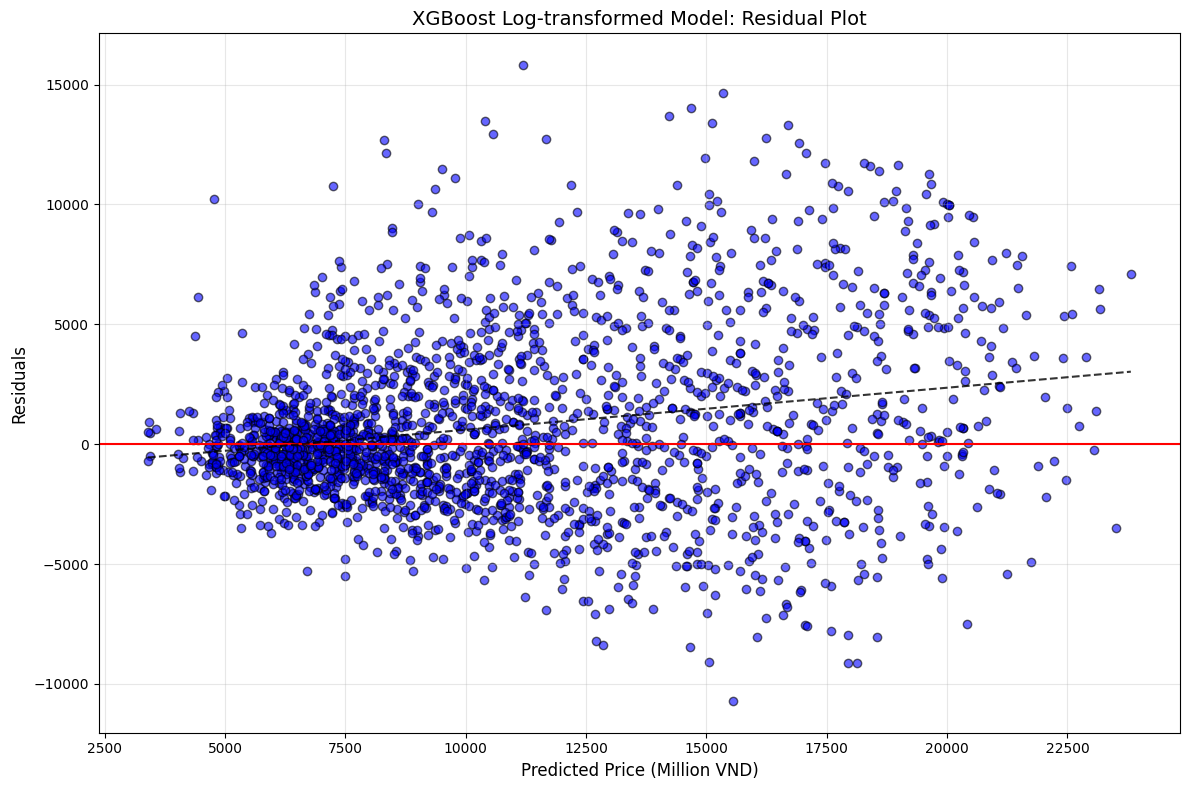

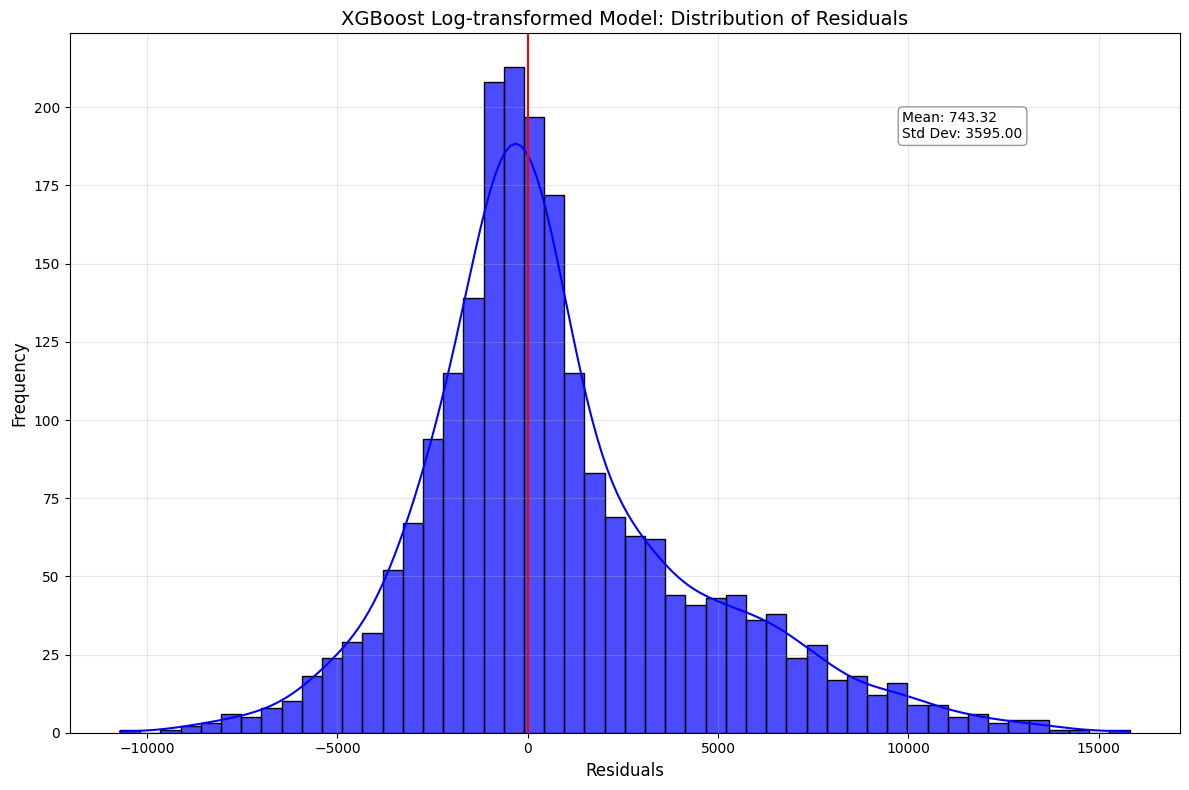

In [68]:
# Visualize predictions vs actual values for the better model
if best_model == "Log-transformed":
    predictions = y_test_pred_xgb_log
    model_title = "Log-transformed Model"
else:
    predictions = y_test_pred_xgb
    model_title = "Original Model"

plt.figure(figsize=(12, 8))
plt.scatter(y_test, predictions, alpha=0.5, color='blue', edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Price (Million VND)', fontsize=12)
plt.ylabel('Predicted Price (Million VND)', fontsize=12)
plt.title(f'XGBoost {model_title}: Actual vs Predicted Price', fontsize=14)
plt.grid(True, alpha=0.3)

# Add annotations for R² and RMSE
if best_model == "Log-transformed":
    plt.annotate(f"R² = {metrics_xgb_log['test_r2']:.4f}\nRMSE = {metrics_xgb_log['test_rmse']:.2f}", 
                xy=(0.05, 0.9), xycoords='axes fraction', 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
else:
    plt.annotate(f"R² = {metrics_xgb['test_r2']:.4f}\nRMSE = {metrics_xgb['test_rmse']:.2f}", 
                xy=(0.05, 0.9), xycoords='axes fraction', 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.tight_layout()
plt.show()

# Plot residuals
residuals = y_test - predictions
plt.figure(figsize=(12, 8))
plt.scatter(predictions, residuals, alpha=0.6, color='blue', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Price (Million VND)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title(f'XGBoost {model_title}: Residual Plot', fontsize=14)
plt.grid(True, alpha=0.3)

# Add trend line for residuals
z = np.polyfit(predictions, residuals, 1)
p = np.poly1d(z)
plt.plot(np.sort(predictions), p(np.sort(predictions)), "k--", alpha=0.8)
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(12, 8))
sns.histplot(residuals, kde=True, bins=50, color='blue', alpha=0.7)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'XGBoost {model_title}: Distribution of Residuals', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='r', linestyle='-')

# Annotate with statistics
plt.annotate(f"Mean: {np.mean(residuals):.2f}\nStd Dev: {np.std(residuals):.2f}", 
             xy=(0.75, 0.85), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.tight_layout()
plt.show()

## 14. Export the Model for Deployment

Now that we've identified the best model, let's export it so it can be used in our Streamlit application.

In [71]:
import joblib

# Save the best model (either log-transformed or original based on our comparison)
if best_model == "Log-transformed":
    joblib.dump(best_pipeline, '../../Application/xgboost_model.joblib')
    print("Saved log-transformed XGBoost model to '../../Application/xgboost_model.joblib'")
else:
    joblib.dump(xgb_model, '../../Application/xgboost_model.joblib')
    print("Saved original XGBoost model to '../../Application/xgboost_model.joblib'")

# Also save a feature list for reference in the app
import pickle
with open('../../Application/model_features.pkl', 'wb') as f:
    pickle.dump({
        'numeric_features': numeric_features,
        'categorical_features': categorical_features,
        'is_log_transformed': best_model == "Log-transformed"
    }, f)
print("Saved feature information to '../../Application/model_features.pkl'")

Saved log-transformed XGBoost model to '../../Application/xgboost_model.joblib'
Saved feature information to '../../Application/model_features.pkl'
